# Eval runs

In [7]:
#! pip install pandas
#! pip install matplotlib
#! pip install scipy
#! pip install seaborn
#! pip install nbconvert
#! pip install matplotlib-venn
! jupyter nbconvert --to HTML PoseErrorAnalysis.ipynb

^C


[NbConvertApp] Converting notebook PoseErrorAnalysis.ipynb to HTML
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 5085418 bytes to PoseErrorAnalysis.html


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
from PIL import Image 
import sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import griddata
sys.path.append("../")  # from src/notebooks to src/

from util.datapipeline.EmbeddingDataset import EmbeddingDataset

pd.set_option('display.max_columns', None)

In [ ]:
def visualize_similarity_to_pos(embeddings, pose_list, center_pose=(0, 0)):
    """
    embeddings: Tensor (V, D)
    pose_list: Tensor (V, 2)
    """

    # Normalize embeddings
    emb_norm = F.normalize(embeddings, p=2, dim=-1)

    # Convert pose list
    pose_tuples = [tuple(map(int, p)) for p in pose_list]

    # Sort by (pitch, yaw)
    sorted_idx = sorted(range(len(pose_tuples)), key=lambda i: (pose_tuples[i][0], pose_tuples[i][1]))
    pose_sorted = [pose_tuples[i] for i in sorted_idx]
    emb_sorted = emb_norm[sorted_idx]

    # Find center pose index
    if center_pose not in pose_sorted:
        raise ValueError(f"Center pose {center_pose} not in pose_list")

    center_idx = pose_sorted.index(center_pose)
    center_emb = emb_sorted[center_idx]

    # Cosine similarities
    similarities = (emb_sorted @ center_emb).cpu().numpy()

    # --- Build sparse 2D grid ---
    pitches = sorted({p for p, _ in pose_sorted})
    yaws    = sorted({y for _, y in pose_sorted})

    pitch_to_idx = {p: i for i, p in enumerate(pitches)}
    yaw_to_idx   = {y: i for i, y in enumerate(yaws)}

    H, W = len(pitches), len(yaws)
    heatmap = np.full((H, W), np.nan)

    # fill known values
    for (pitch, yaw), sim in zip(pose_sorted, similarities):
        heatmap[pitch_to_idx[pitch], yaw_to_idx[yaw]] = sim

    # --- Interpolate missing cells ---
    pitch_coords = np.array([p for p, _ in pose_sorted])
    yaw_coords   = np.array([y for _, y in pose_sorted])
    sim_values   = np.array(similarities)

    # target grid
    grid_pitch, grid_yaw = np.meshgrid(pitches, yaws, indexing="ij")

    # Try cubic → fallback to linear → fallback to nearest
    heatmap_interp = griddata(
        (pitch_coords, yaw_coords),
        sim_values,
        (grid_pitch, grid_yaw),
        method="cubic",
        fill_value=np.nan
    )*100

    # Fill remaining gaps with linear interpolation
    mask = np.isnan(heatmap_interp)
    if np.any(mask):
        heatmap_interp[mask] = griddata(
            (pitch_coords, yaw_coords),
            sim_values,
            (grid_pitch, grid_yaw),
            method="linear"
        )[mask]

    # Fill any final gaps with nearest neighbor
    mask = np.isnan(heatmap_interp)
    if np.any(mask):
        heatmap_interp[mask] = griddata(
            (pitch_coords, yaw_coords),
            sim_values,
            (grid_pitch, grid_yaw),
            method="nearest"
        )[mask]

    annot_grid = np.round(heatmap_interp, 2)

    # --- Plot heatmap ---
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        heatmap_interp,
        xticklabels=yaws,
        yticklabels=pitches,
        cmap="viridis",
        square=True,
        vmin=0,
        vmax=100,
        annot=annot_grid,
    )

    plt.title(f"Cosine Similarity to Center Pose {center_pose}")
    plt.xlabel("Yaw")
    plt.ylabel("Pitch")
    plt.tight_layout()
    plt.show()


dataset = EmbeddingDataset("F:\\Face\\data\\dataset13_emb\\rgb_bff_crop187_emb-irseglintr18")
sample = dataset[0]
emb, label, scan_id, true_p, path = sample  # emb = (V, D), true_p = (V, 2)

visualize_similarity_to_pos(emb, true_p, center_pose=(0, 0))
visualize_similarity_to_pos(emb, true_p, center_pose=(35, 0))
visualize_similarity_to_pos(emb, true_p, center_pose=(0, 45))
visualize_similarity_to_pos(emb, true_p, center_pose=(35, 35))


FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'F:\\Face\\data\\dataset14_emb\\rgb_bff_crop261_emb-irseglintr18'

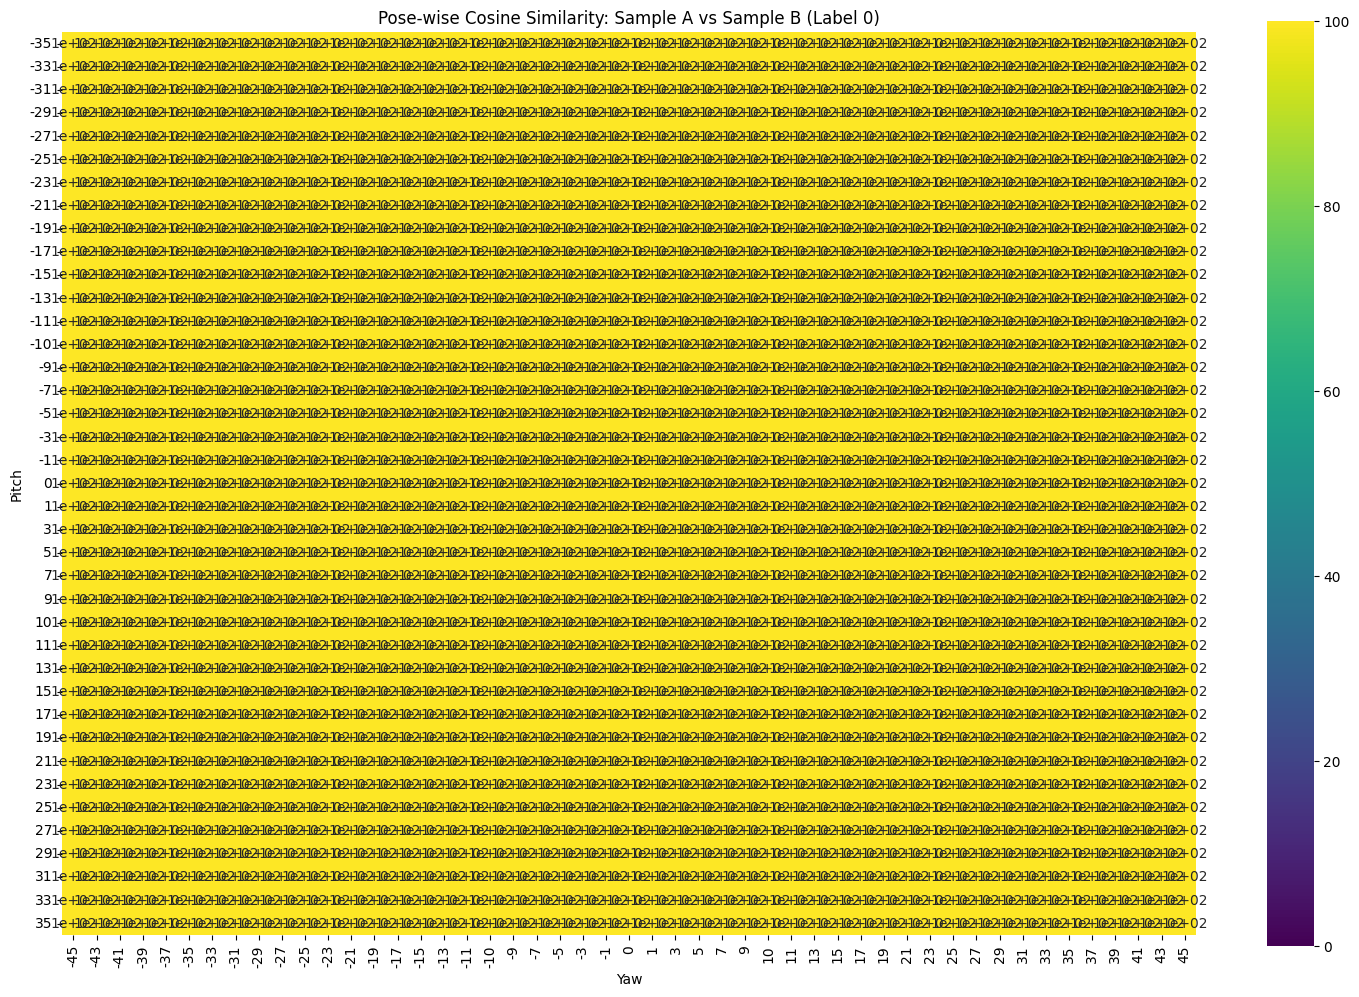

0 0


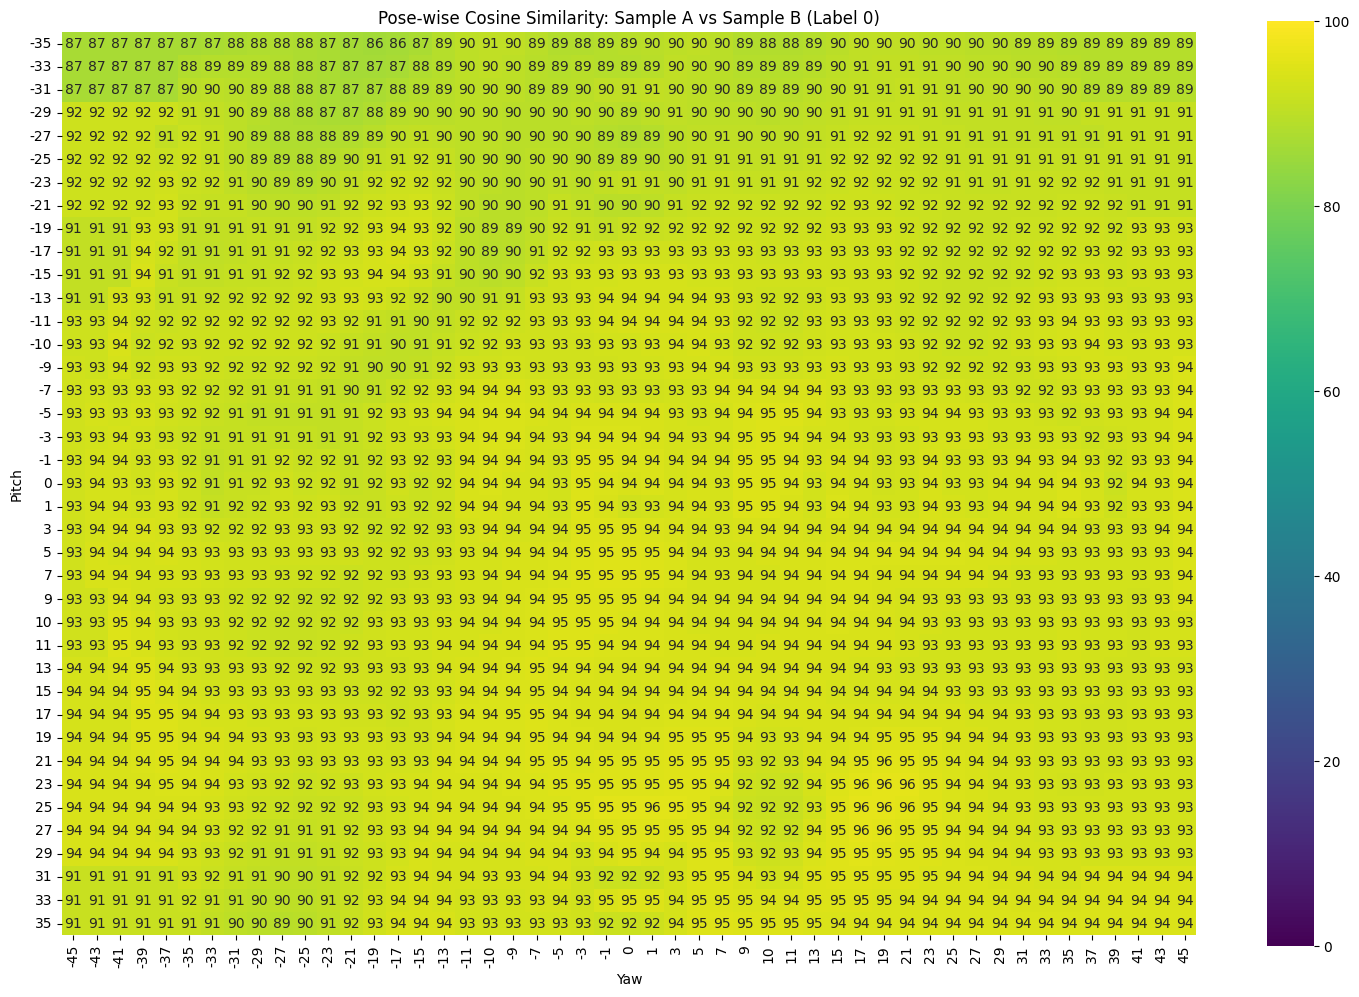

0 0


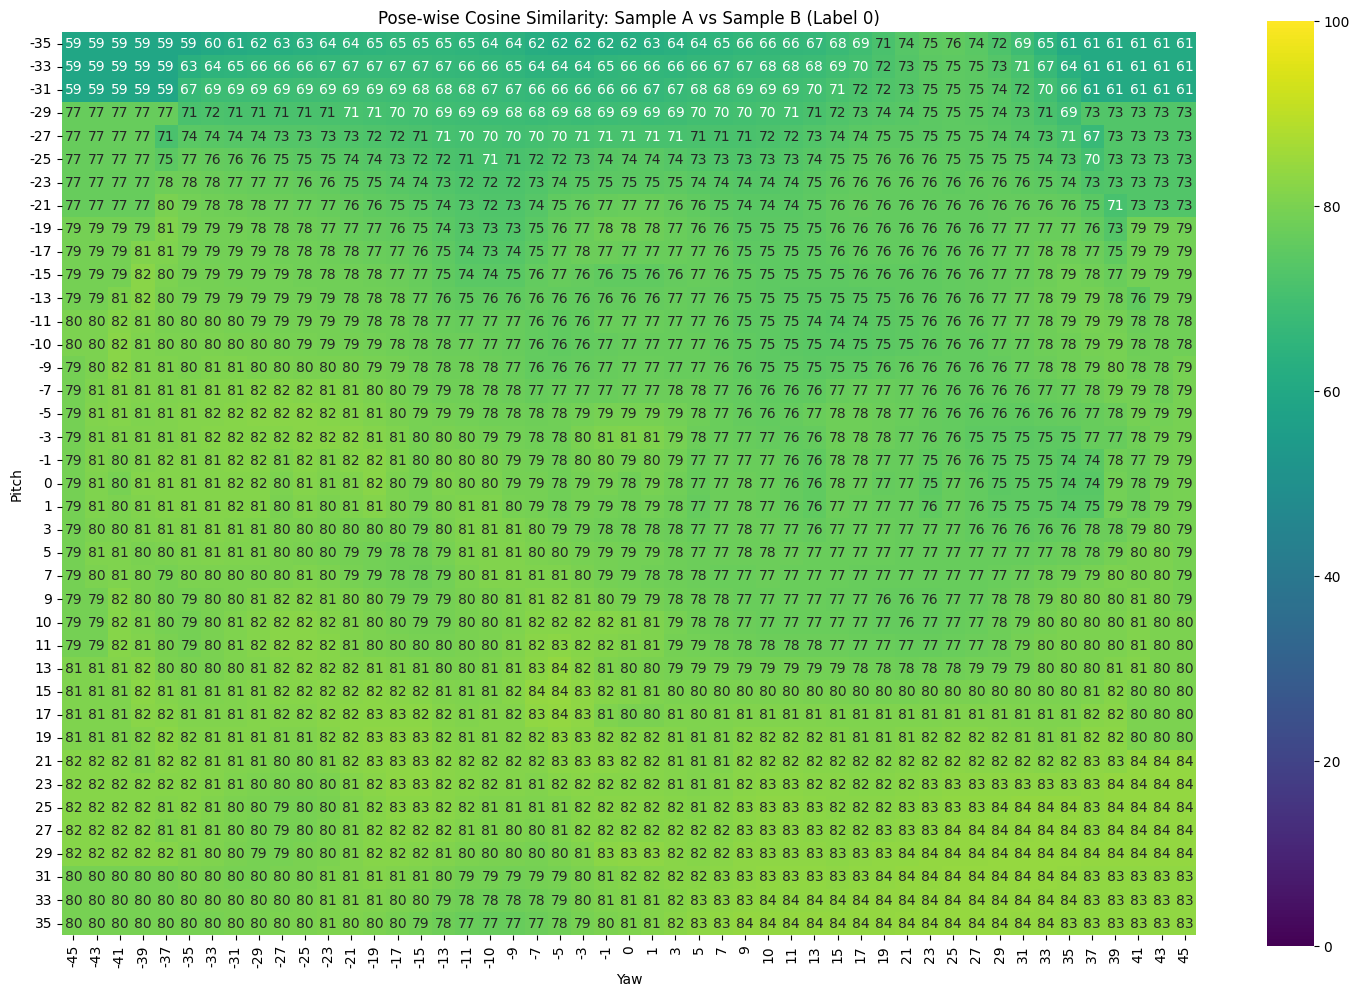

0 0


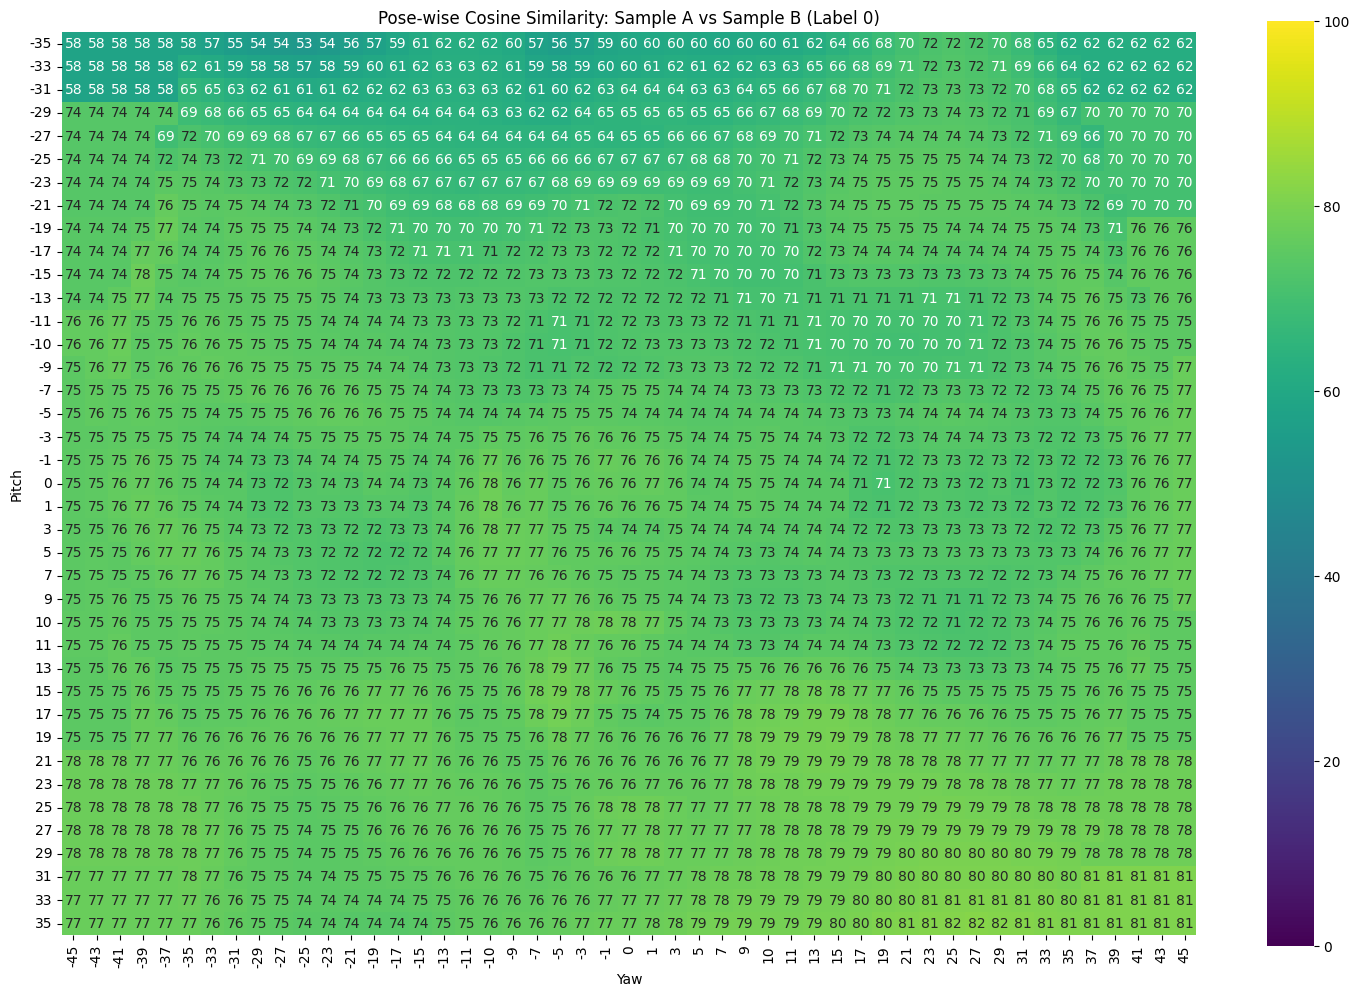

0 1
Samples have different labels: 0 vs 1


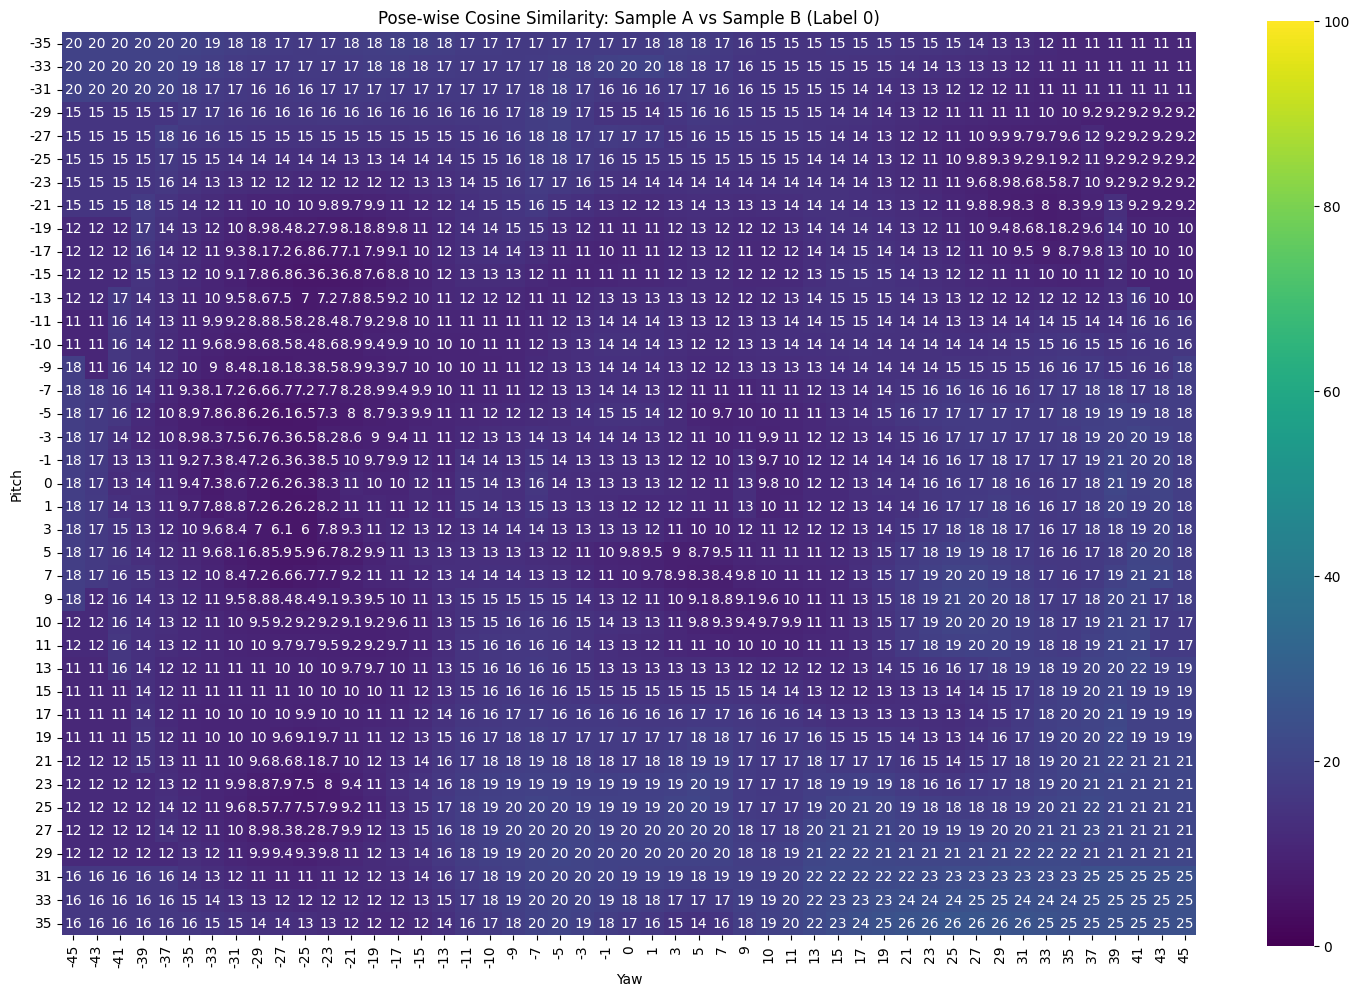

In [ ]:
def visualize_posewise_similarity(sample_a, sample_b):
    emb_a, label_a, _, poses_a, _ = sample_a
    emb_b, label_b, _, poses_b, _ = sample_b

    if label_a != label_b:
        print(f"Samples have different labels: {label_a} vs {label_b}")

    emb_a = F.normalize(emb_a, p=2, dim=-1)
    emb_b = F.normalize(emb_b, p=2, dim=-1)

    poses_a = [tuple(map(int, p)) for p in poses_a]
    poses_b = [tuple(map(int, p)) for p in poses_b]

    all_pitches = sorted(set([p for p, _ in poses_a] + [p for p, _ in poses_b]))
    all_yaws    = sorted(set([y for _, y in poses_a] + [y for _, y in poses_b]))

    pitch_to_idx = {p:i for i,p in enumerate(all_pitches)}
    yaw_to_idx   = {y:i for i,y in enumerate(all_yaws)}

    grid = np.full((len(all_pitches), len(all_yaws)), np.nan)

    pose_b_to_idx = {p: i for i, p in enumerate(poses_b)}

    points = []
    values = []

    for i, pose in enumerate(poses_a):
        if pose in pose_b_to_idx:
            j = pose_b_to_idx[pose]
            sim = (emb_a[i] @ emb_b[j]).item()
            # clamp similarity to [0,1]
            sim = max(0.0, min(1.0, sim))
            grid[pitch_to_idx[pose[0]], yaw_to_idx[pose[1]]] = sim

            points.append([pose[0], pose[1]])
            values.append(sim)

    points = np.array(points)
    values = np.array(values)*100

    grid_pitch, grid_yaw = np.meshgrid(all_pitches, all_yaws, indexing="ij")
    grid_interp = griddata(points, values, (grid_pitch, grid_yaw), method="cubic")

    mask = np.isnan(grid_interp)
    if np.any(mask):
        grid_interp[mask] = griddata(points, values, (grid_pitch, grid_yaw), method="nearest")[mask]

    # round values for annotation
    annot_grid = np.round(grid_interp, 2)

    plt.figure(figsize=(15,10))
    sns.heatmap(
        grid_interp,
        xticklabels=all_yaws,
        yticklabels=all_pitches,
        cmap="viridis",
        square=True,
        vmin=0,
        vmax=100,
        annot=annot_grid,
        #fmt=".1f"
    )
    plt.xlabel("Yaw")
    plt.ylabel("Pitch")
    plt.title(f"Pose-wise Cosine Similarity: Sample A vs Sample B (Label {label_a})")
    plt.tight_layout()
    plt.show()

sample_a = dataset[0]
visualize_posewise_similarity(sample_a, sample_a)

sample_a = dataset[0]
sample_b = dataset[1]
print(sample_a[1], sample_b[1])
visualize_posewise_similarity(sample_a, sample_b)

sample_a = dataset[0]
sample_b = dataset[2]
print(sample_a[1], sample_b[1])
visualize_posewise_similarity(sample_a, sample_b)


sample_a = dataset[1]
sample_b = dataset[2]
print(sample_a[1], sample_b[1])
visualize_posewise_similarity(sample_a, sample_b)


sample_a = dataset[0]
sample_b = dataset[3]
print(sample_a[1], sample_b[1])
visualize_posewise_similarity(sample_a, sample_b)

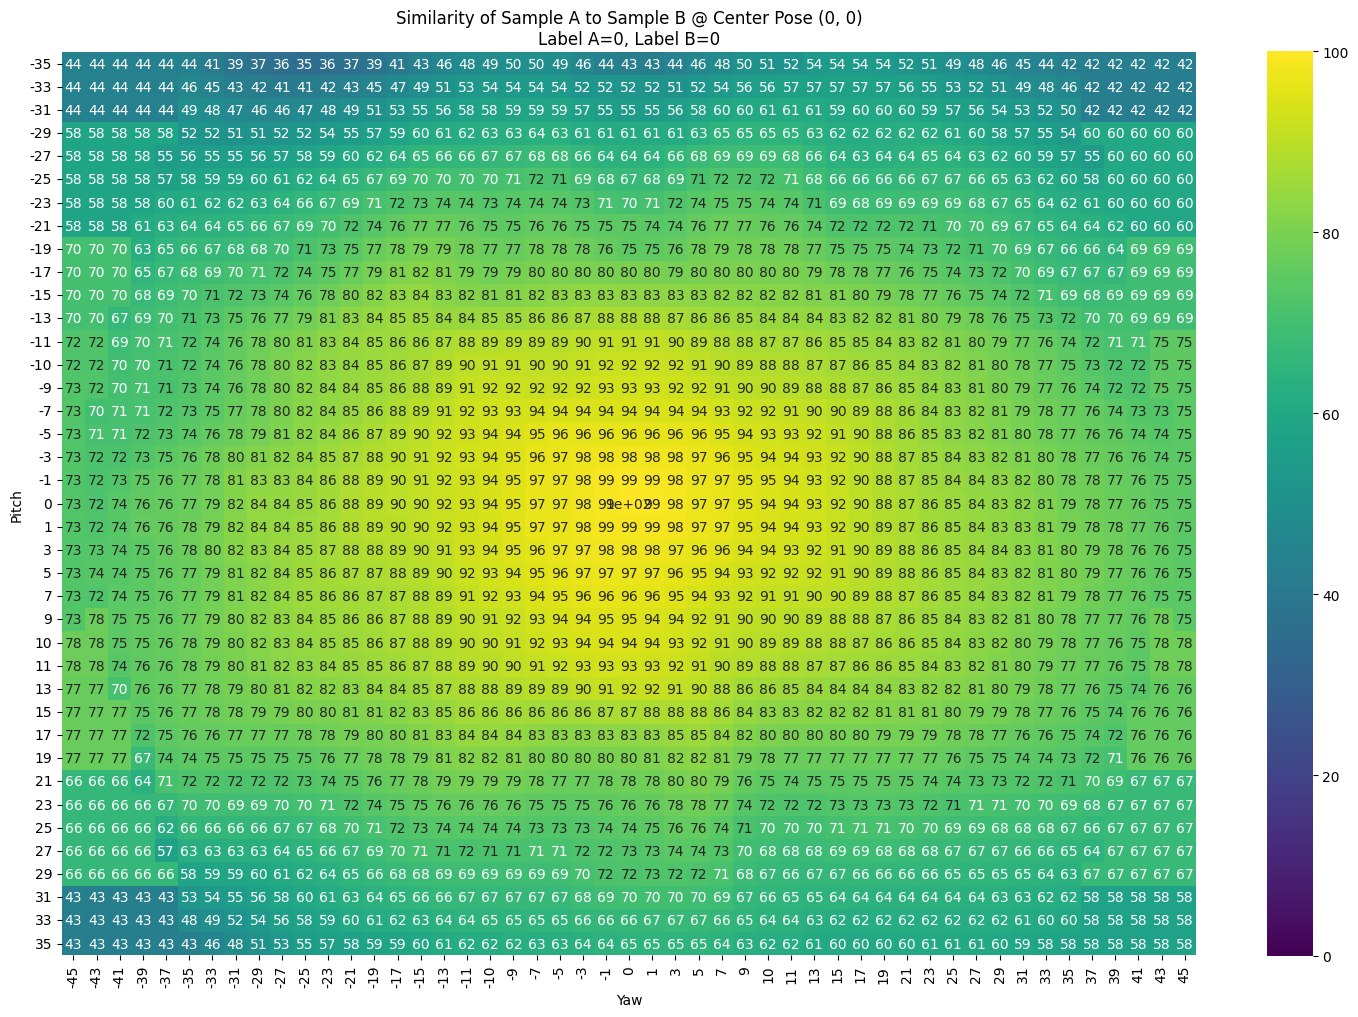

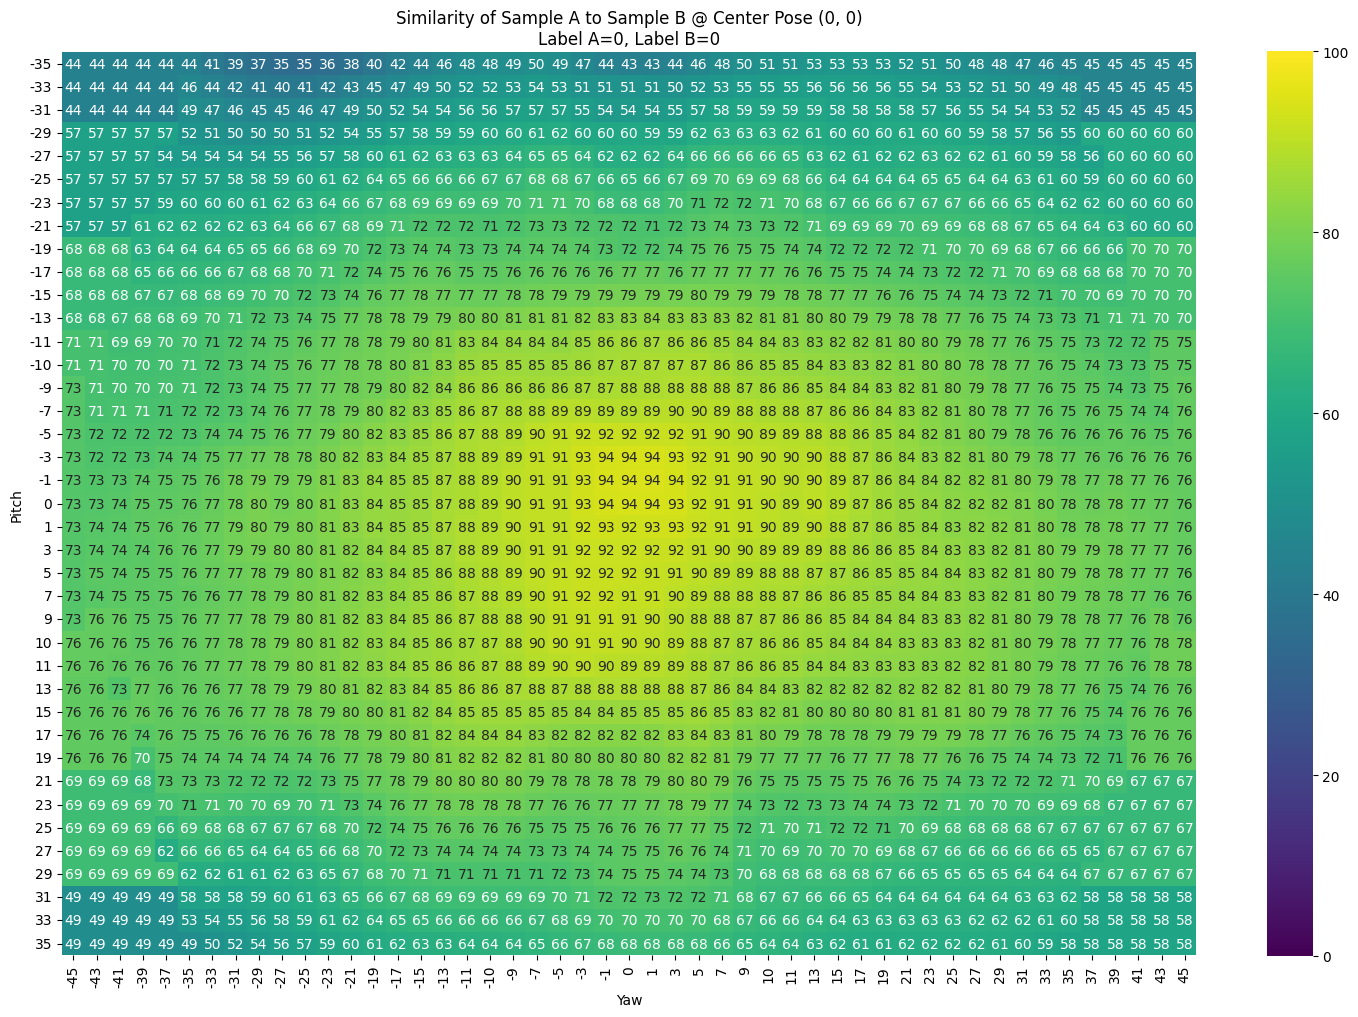

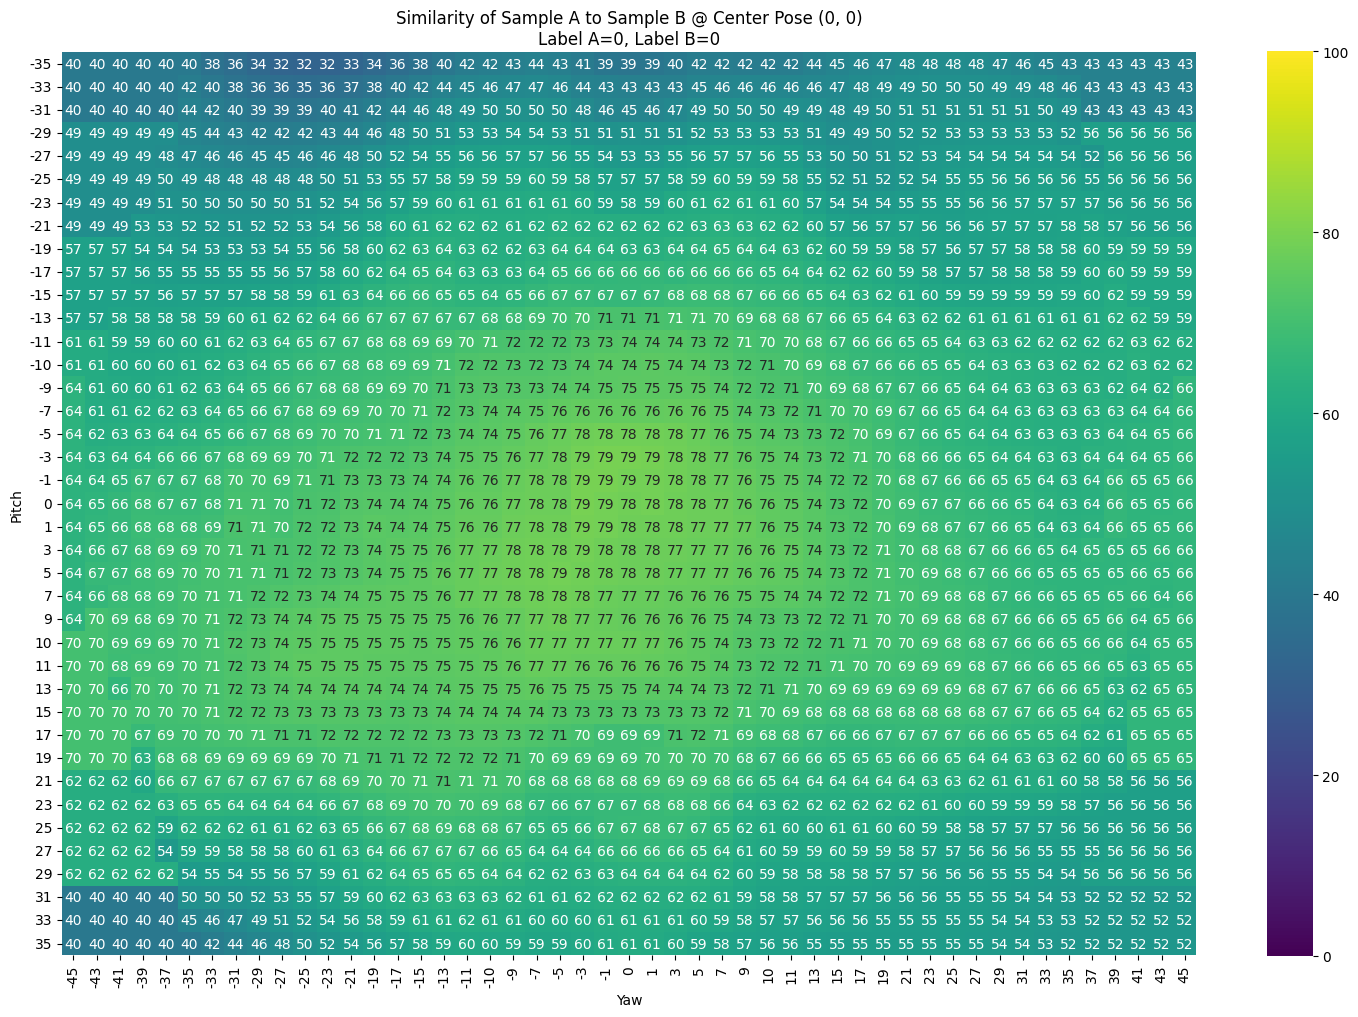

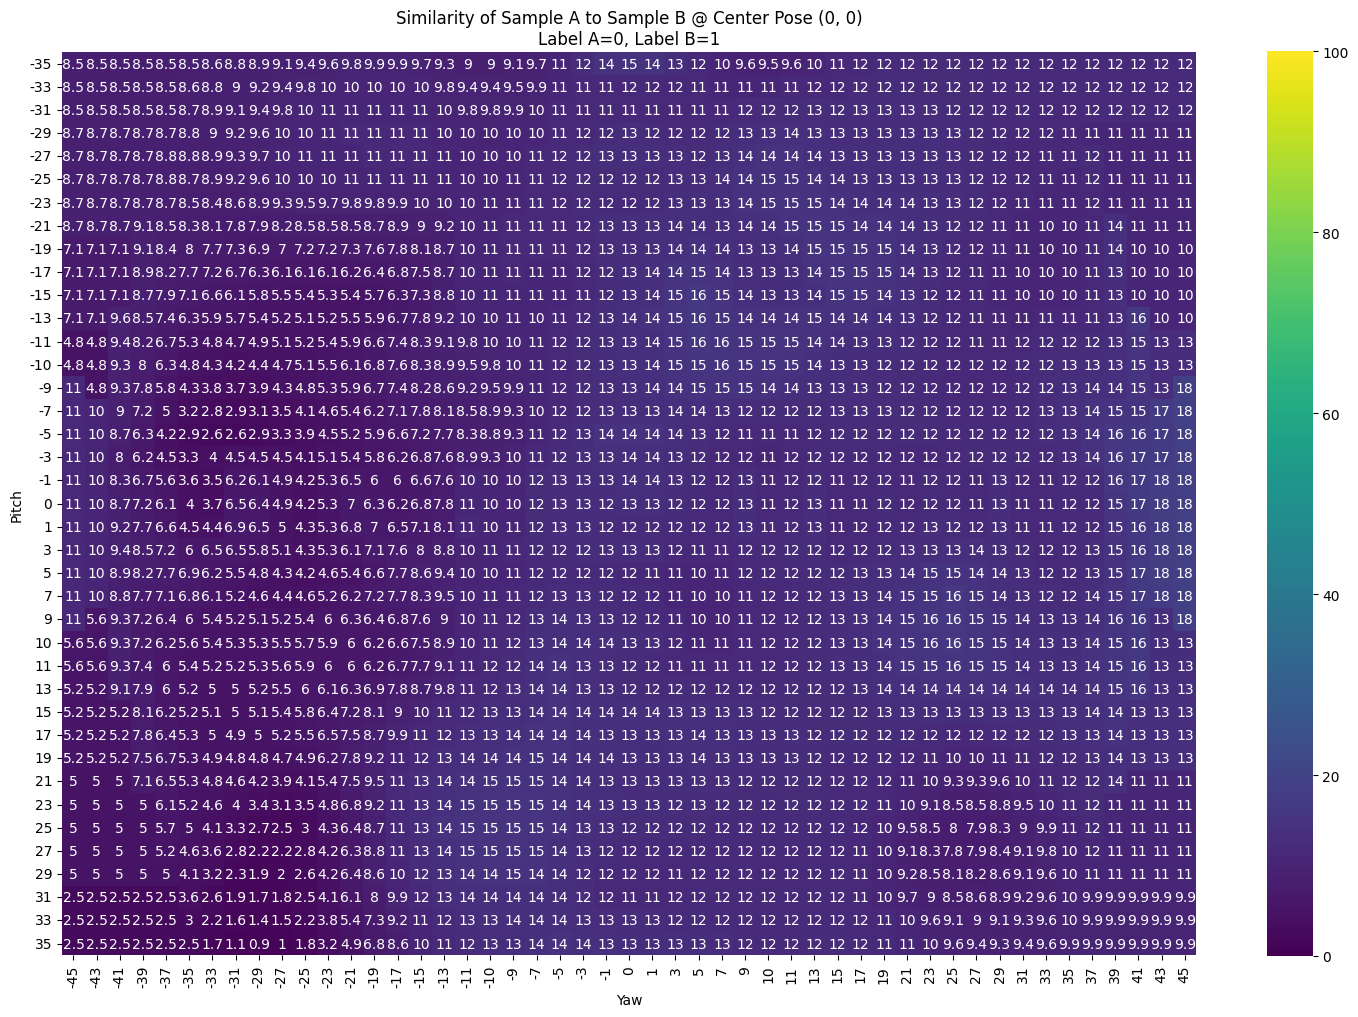

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata


def visualize_posewise_similarity_centered(sample_a, sample_b, center_pose=(0,0)):
    """
    Compare ALL embeddings of sample_a against ONLY the embedding of sample_b at center_pose.
    Creates a smooth heatmap sorted by (pitch,yaw).
    """

    emb_a, label_a, _, poses_a, _ = sample_a
    emb_b, label_b, _, poses_b, _ = sample_b

    # ---- Normalize ----
    emb_a = F.normalize(emb_a, p=2, dim=-1)
    emb_b = F.normalize(emb_b, p=2, dim=-1)

    poses_a = [tuple(map(int, p)) for p in poses_a]
    poses_b = [tuple(map(int, p)) for p in poses_b]

    # ---- Sort pose grid ----
    pitches = sorted({p for p, _ in poses_a})
    yaws    = sorted({y for _, y in poses_a})

    pitch_to_idx = {p:i for i,p in enumerate(pitches)}
    yaw_to_idx   = {y:i for i,y in enumerate(yaws)}

    H, W = len(pitches), len(yaws)
    heat = np.full((H, W), np.nan)

    # ---- Get B's center embedding ----
    if center_pose not in poses_b:
        raise ValueError(f"Center pose {center_pose} not present in sample_b")

    center_idx = poses_b.index(center_pose)
    center_emb = emb_b[center_idx]

    # ---- Compute cosine sims (A → center of B) ----
    similarities = (emb_a @ center_emb).cpu().numpy()
    similarities = np.clip(similarities, 0, 1) * 100  # convert to % for visualization

    # ---- Fill sparse heatmap matrix ----
    points = []
    values = []

    for pose, sim in zip(poses_a, similarities):
        pi, yi = pitch_to_idx[pose[0]], yaw_to_idx[pose[1]]
        heat[pi, yi] = sim
        points.append([pose[0], pose[1]])
        values.append(sim)

    points = np.array(points)
    values = np.array(values)

    # ---- Build full grid ----
    grid_pitch, grid_yaw = np.meshgrid(pitches, yaws, indexing="ij")

    # cubic → linear → nearest fallback interpolation
    heat_interp = griddata(points, values, (grid_pitch, grid_yaw), method="cubic")

    mask = np.isnan(heat_interp)
    if np.any(mask):
        heat_interp[mask] = griddata(points, values, (grid_pitch, grid_yaw), method="linear")[mask]

    mask = np.isnan(heat_interp)
    if np.any(mask):
        heat_interp[mask] = griddata(points, values, (grid_pitch, grid_yaw), method="nearest")[mask]

    # ---- Annotation grid (rounded %) ----
    annot_grid = np.round(heat_interp, 1)

    # ---- Plot ----
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        heat_interp,
        xticklabels=yaws,
        yticklabels=pitches,
        cmap="viridis",
        vmin=0,
        vmax=100,
        square=True,
        annot=annot_grid,
    )

    plt.title(
        f"Similarity of Sample A to Sample B @ Center Pose {center_pose}\n"
        f"Label A={label_a}, Label B={label_b}"
    )
    plt.xlabel("Yaw")
    plt.ylabel("Pitch")
    plt.tight_layout()
    plt.show()


sample_a1 = dataset[0]
sample_a2 = dataset[1]
sample_a3 = dataset[2]
sample_b1 = dataset[3]

visualize_posewise_similarity_centered(sample_a1, sample_a1, center_pose=(0,0))
visualize_posewise_similarity_centered(sample_a1, sample_a2, center_pose=(0,0))
visualize_posewise_similarity_centered(sample_a1, sample_a3, center_pose=(0,0))
visualize_posewise_similarity_centered(sample_a1, sample_b1, center_pose=(0,0))

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from scipy.interpolate import LinearNDInterpolator


def compute_average_heatmaps(dataset, center_pose=(0, 0), B_ratio=250):
    device = dataset[0][0].device
    N = len(dataset)

    # --- Pose grid from first sample ---
    _, _, _, poses_ref, _ = dataset[0]
    poses_ref = np.array([tuple(map(int, p)) for p in poses_ref])

    pitches = np.unique(poses_ref[:, 0])
    yaws    = np.unique(poses_ref[:, 1])
    H, W = len(pitches), len(yaws)

    grid_pitch, grid_yaw = np.meshgrid(pitches, yaws, indexing="ij")
    grid_points = np.stack([grid_pitch.ravel(), grid_yaw.ravel()], axis=1)

    # --- Precompute dataset ---
    embeddings = []
    labels = []
    center_indices = []

    for emb, label, _, poses, _ in dataset:
        embeddings.append(F.normalize(emb, dim=-1))
        labels.append(label)

        poses = [tuple(map(int, p)) for p in poses]
        center_indices.append(poses.index(center_pose) if center_pose in poses else None)

    embeddings = embeddings
    labels = np.array(labels)

    # --- B sampling ---
    B_indices = np.random.choice(N, size=N // B_ratio, replace=False)

    same_sum = np.zeros((H, W), dtype=np.float32)
    diff_sum = np.zeros((H, W), dtype=np.float32)
    count_same = 0
    count_diff = 0

    # --- Main loop ---
    for i in tqdm(range(N), desc="Fast outer loop"):
        emb_a = embeddings[i]
        label_a = labels[i]

        # A pose points
        points_a = poses_ref

        for j in B_indices:
            center_idx = center_indices[j]
            if center_idx is None:
                continue

            emb_center = embeddings[j][center_idx]

            sims = torch.matmul(emb_a, emb_center).clamp(0, 1).mul(100)
            sims_np = sims.cpu().numpy()

            interp = LinearNDInterpolator(points_a, sims_np, fill_value=np.nan)
            heat = interp(grid_points).reshape(H, W)

            nan_mask = np.isnan(heat)
            if nan_mask.any():
                heat[nan_mask] = np.nanmean(heat)

            if label_a == labels[j]:
                same_sum += heat
                count_same += 1
            else:
                diff_sum += heat
                count_diff += 1

    return (
        same_sum / max(count_same, 1),
        diff_sum / max(count_diff, 1),
        pitches,
        yaws,
    )



avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset)

Fast outer loop: 100%|██████████| 18550/18550 [2:40:44<00:00,  1.92it/s]  


Compute distances: 100%|██████████| 19786/19786 [14:51<00:00, 22.19it/s]


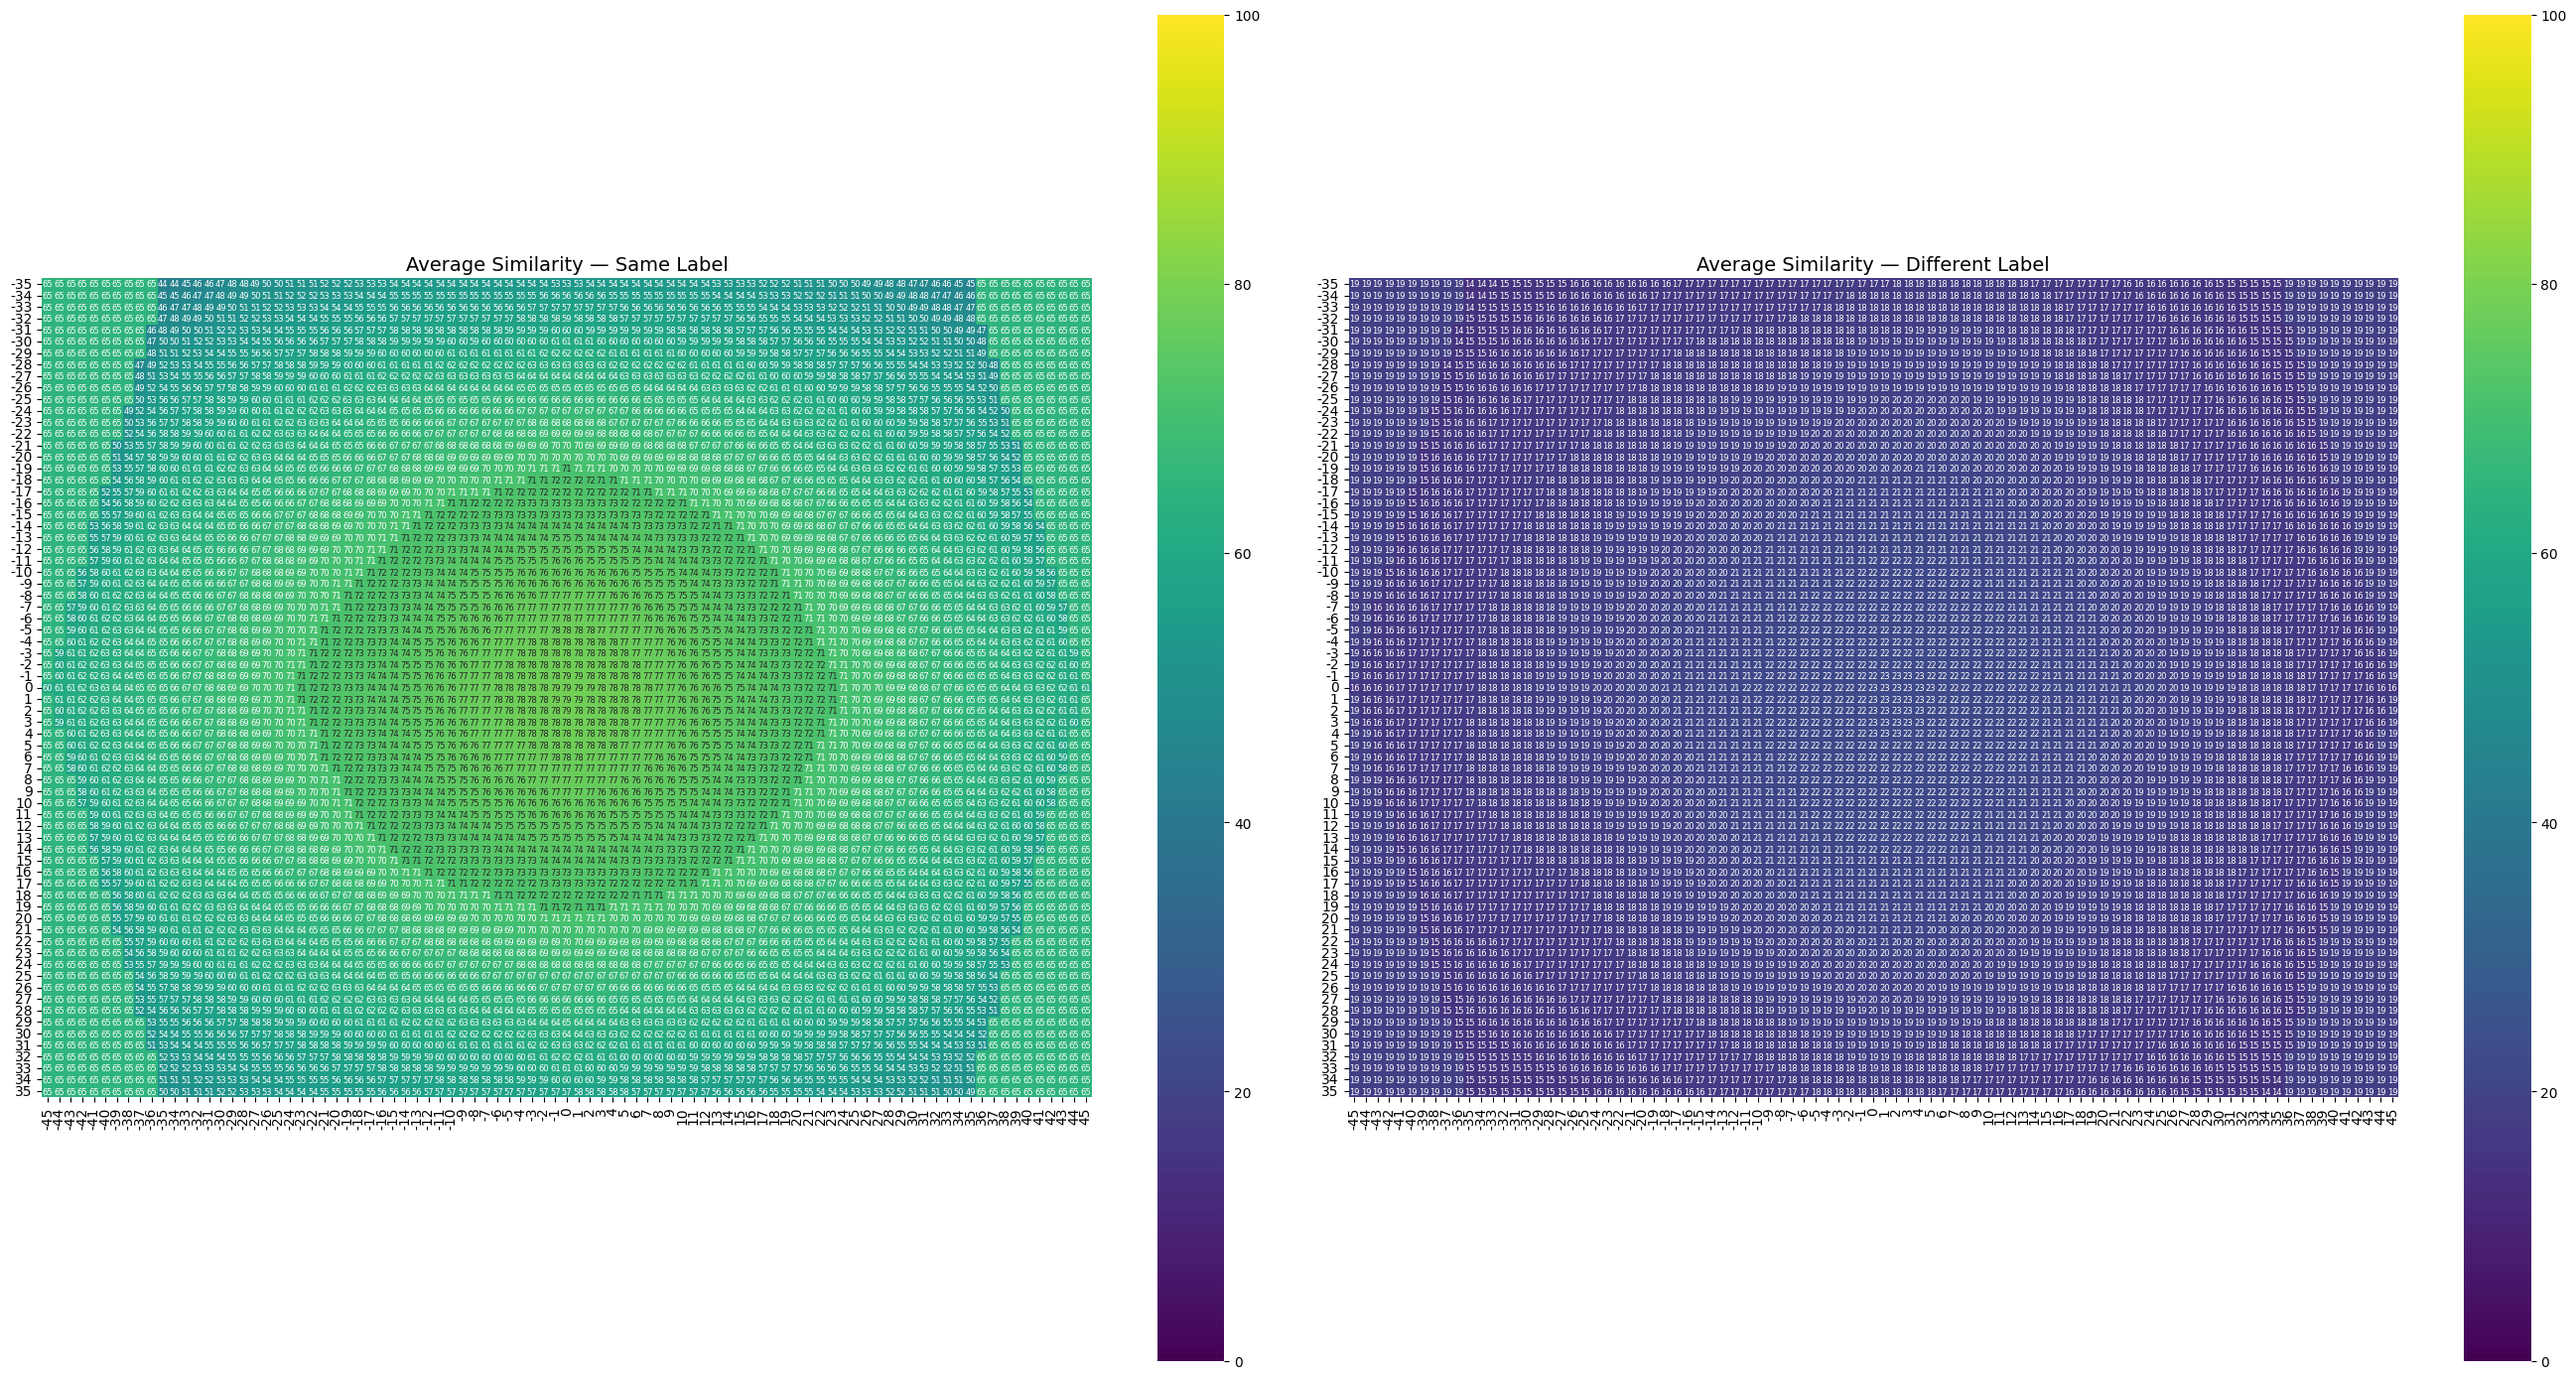

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from scipy.interpolate import LinearNDInterpolator


def compute_average_heatmaps(dataset, center_pose=(0, 0), B_ratio=50):
    device = dataset[0][0].device
    N = len(dataset)

    # --- Pose grid from first sample ---
    _, _, _, poses_ref, _ = dataset[0]
    poses_ref = np.array([tuple(map(int, p)) for p in poses_ref])

    pitches = np.unique(poses_ref[:, 0])
    yaws    = np.unique(poses_ref[:, 1])
    H, W = len(pitches), len(yaws)

    grid_pitch, grid_yaw = np.meshgrid(pitches, yaws, indexing="ij")
    grid_points = np.stack([grid_pitch.ravel(), grid_yaw.ravel()], axis=1)

    num_poses = len(poses_ref)

    # --- Precompute ONLY labels + center indices ---
    labels = np.empty(N, dtype=np.int32)
    center_indices = np.full(N, -1, dtype=np.int32)

    for i, (_, label, _, poses, _) in enumerate(tqdm(dataset, desc="Prepare Dataset")):
        labels[i] = label
        poses = [tuple(map(int, p)) for p in poses]
        if center_pose in poses:
            center_indices[i] = poses.index(center_pose)

    # --- B sampling ---
    B_indices = np.random.choice(N, size=N // B_ratio, replace=False)

    # --- Accumulators in pose space ---
    same_pose_sum = np.zeros(num_poses, dtype=np.float32)
    diff_pose_sum = np.zeros(num_poses, dtype=np.float32)
    same_count = 0
    diff_count = 0

    # --- Main loop (lazy embedding loading) ---
    for i in tqdm(range(N), desc="Compute distances"):
        emb_a, label_a, _, _, _ = dataset[i]
        emb_a = F.normalize(emb_a, dim=-1)

        for j in B_indices:
            center_idx = center_indices[j]
            if center_idx < 0:
                continue

            emb_j, _, _, _, _ = dataset[j]
            emb_center = F.normalize(emb_j[center_idx], dim=-1)

            sims = torch.matmul(emb_a, emb_center).clamp(0, 1).mul(100)
            sims_np = sims.cpu().numpy()

            if label_a == labels[j]:
                same_pose_sum += sims_np
                same_count += 1
            else:
                diff_pose_sum += sims_np
                diff_count += 1

    # --- Average in pose space ---
    same_pose_avg = same_pose_sum / max(same_count, 1)
    diff_pose_avg = diff_pose_sum / max(diff_count, 1)

    # --- Interpolate ONCE ---
    interp_same = LinearNDInterpolator(poses_ref, same_pose_avg, fill_value=np.nan)
    interp_diff = LinearNDInterpolator(poses_ref, diff_pose_avg, fill_value=np.nan)

    heat_same = interp_same(grid_points).reshape(H, W)
    heat_diff = interp_diff(grid_points).reshape(H, W)

    # --- NaN fix ---
    if np.isnan(heat_same).any():
        heat_same[np.isnan(heat_same)] = np.nanmean(heat_same)

    if np.isnan(heat_diff).any():
        heat_diff[np.isnan(heat_diff)] = np.nanmean(heat_diff)

    return heat_same, heat_diff, pitches, yaws

dataset = EmbeddingDataset("C:\\Users\\Eduard\\Desktop\\Face\\dataset14_emb\\rgb_bff_crop261_emb-irseglintr18", disable_tqdm=False)
avg_same, avg_diff, pitches, yaws = compute_average_heatmaps(dataset)

plt.figure(figsize=(27, 14))

plt.subplot(1, 2, 1)
sns.heatmap(
    avg_same,
    xticklabels=yaws,
    yticklabels=pitches,
    vmin=0,
    vmax=100,
    cmap="viridis",
    square=True,
    annot=True,         
    fmt=".0f",           
    annot_kws={"size": 6}
)
plt.title("Average Similarity — Same Label", fontsize=14)

plt.subplot(1, 2, 2)
sns.heatmap(
    avg_diff,
    xticklabels=yaws,
    yticklabels=pitches,
    vmin=0,
    vmax=100,
    cmap="viridis",
    square=True,
    annot=True,
    fmt=".0f",
    annot_kws={"size": 6}
)
plt.title("Average Similarity — Different Label", fontsize=14)

plt.tight_layout()
plt.show()

### Headpose aligned comparison

Compute distances: 100%|██████████| 19786/19786 [26:42<00:00, 12.35it/s]


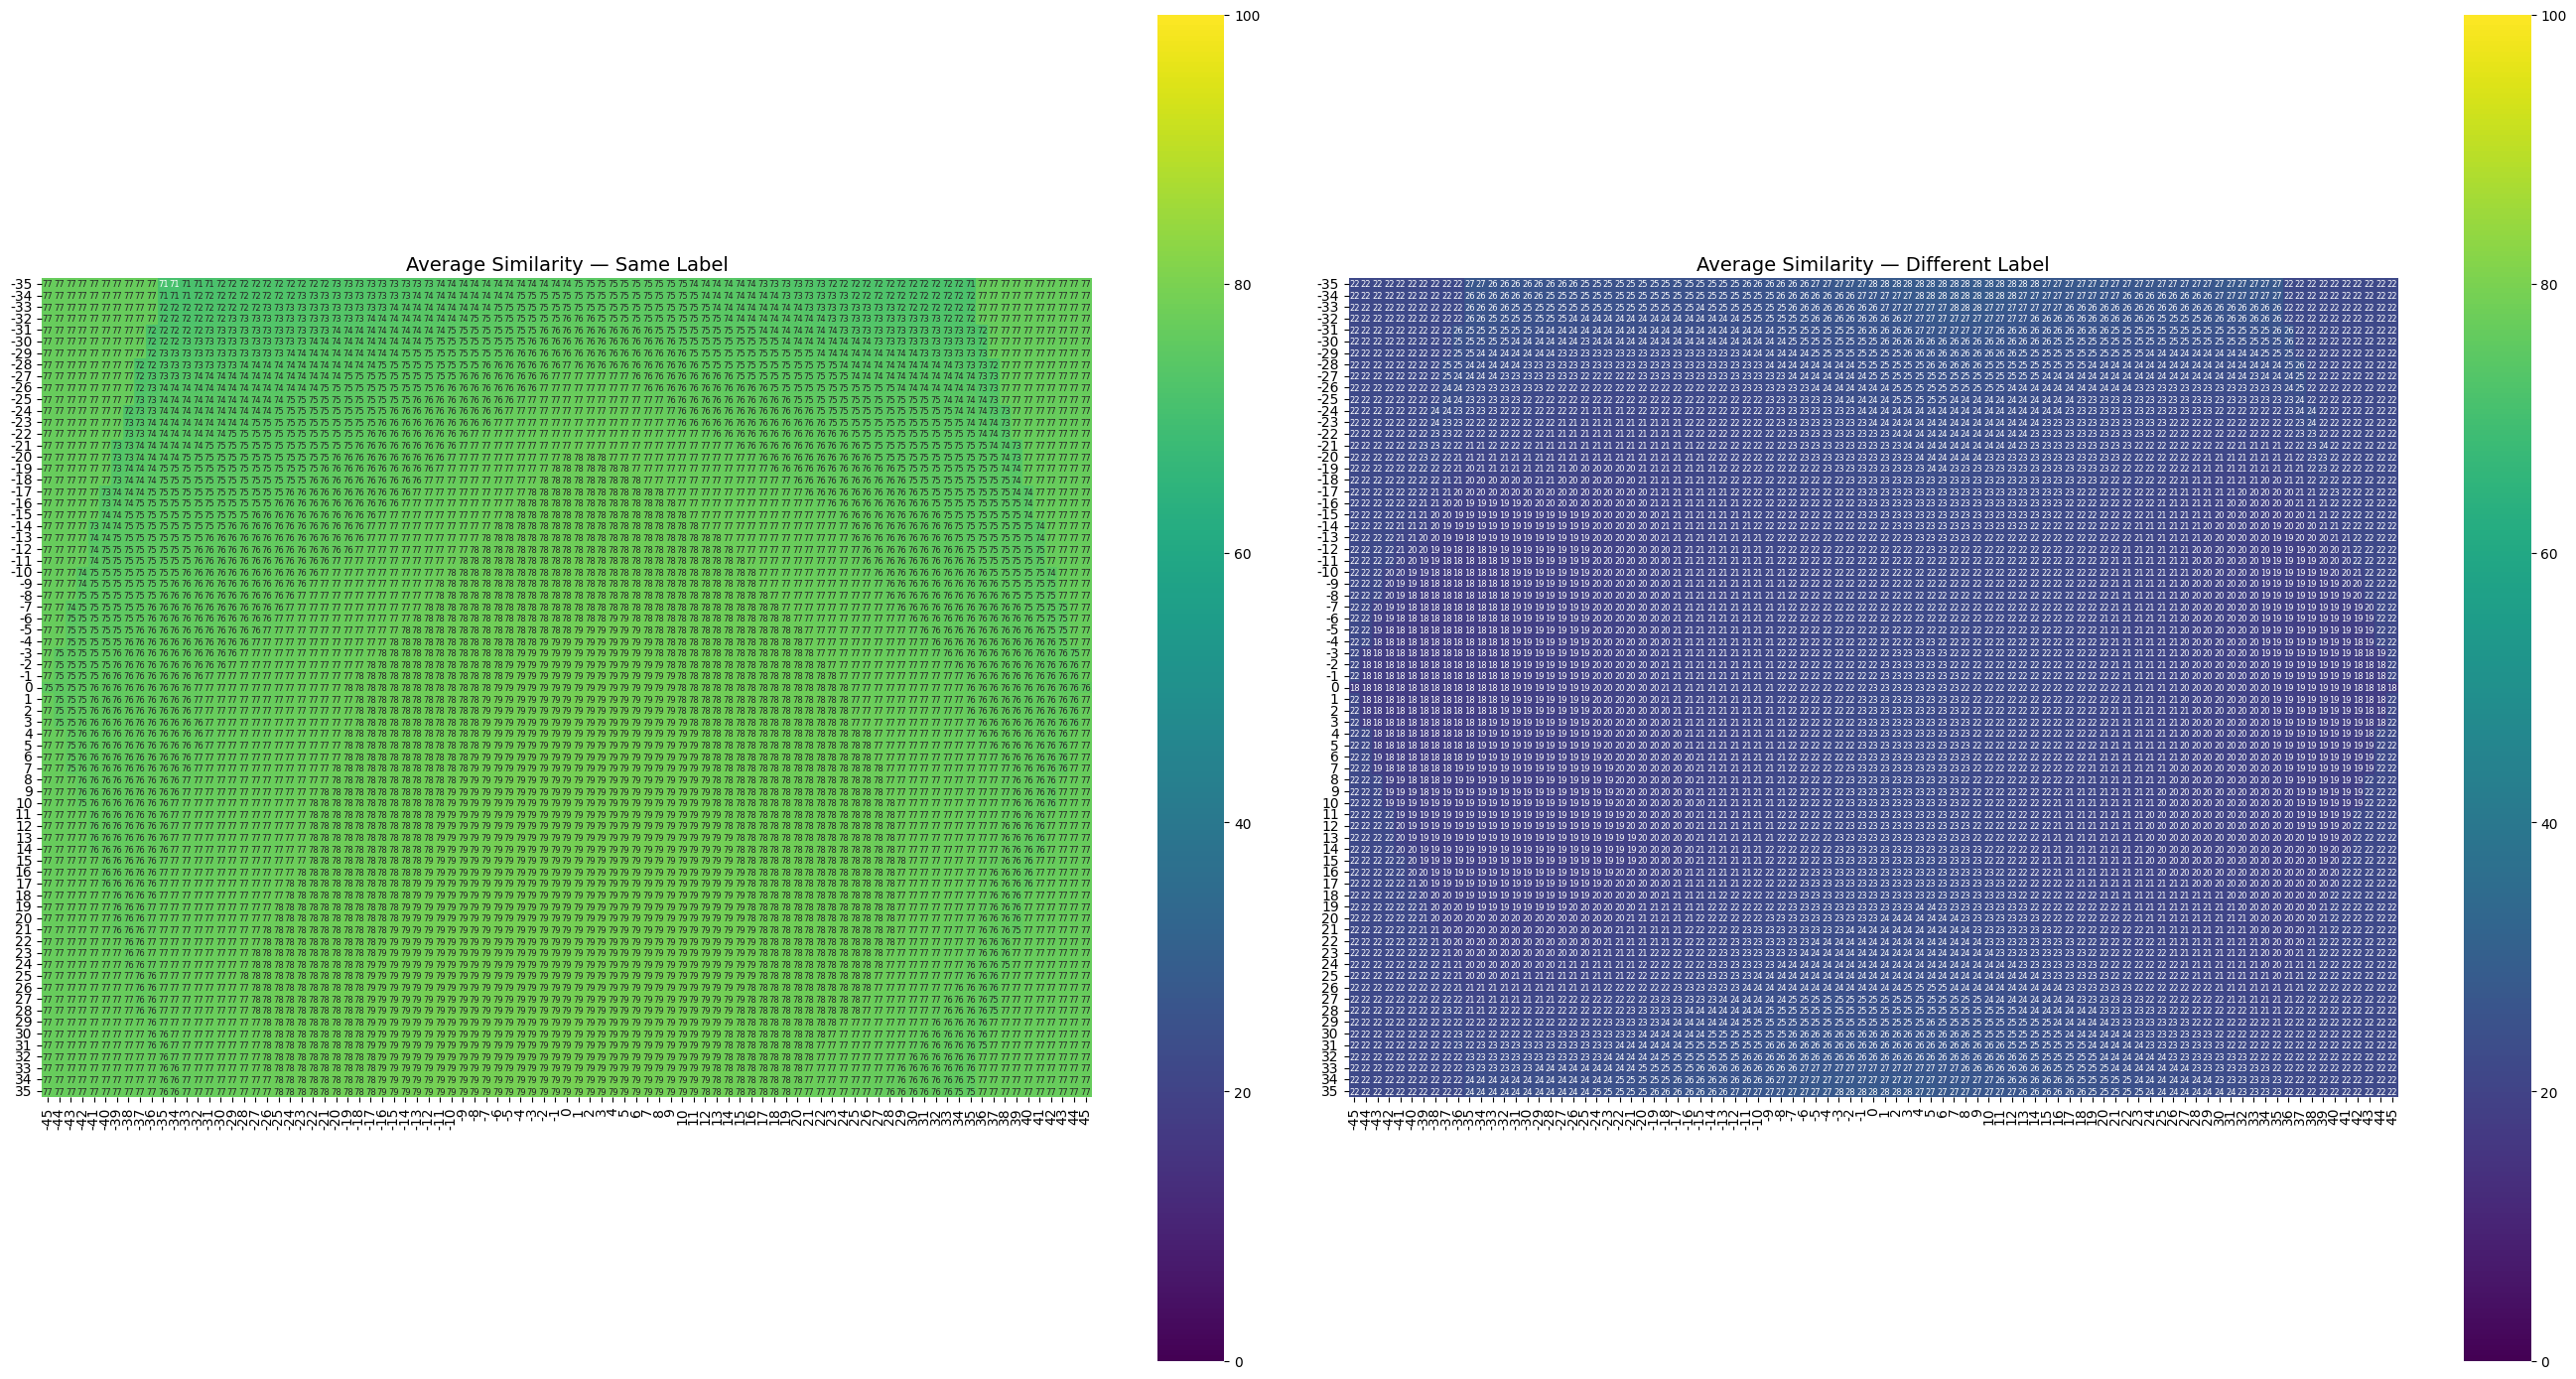

In [10]:
def compute_average_heatmaps_pairwise(dataset, B_ratio=50):
    device = dataset[0][0].device
    N = len(dataset)

    # --- Pose grid from first sample ---
    _, _, _, poses_ref, _ = dataset[0]
    poses_ref = np.array([tuple(map(int, p)) for p in poses_ref])

    pitches = np.unique(poses_ref[:, 0])
    yaws    = np.unique(poses_ref[:, 1])
    H, W = len(pitches), len(yaws)

    grid_pitch, grid_yaw = np.meshgrid(pitches, yaws, indexing="ij")
    grid_points = np.stack([grid_pitch.ravel(), grid_yaw.ravel()], axis=1)

    num_poses = len(poses_ref)

    # --- Precompute labels ---
    labels = np.empty(N, dtype=np.int32)
    for i, (_, label, _, _, _) in enumerate(tqdm(dataset, desc="Prepare Dataset")):
        labels[i] = label

    # --- B sampling ---
    B_indices = np.random.choice(N, size=N // B_ratio, replace=False)

    # --- Accumulators (pose-wise) ---
    same_pose_sum = np.zeros(num_poses, dtype=np.float32)
    diff_pose_sum = np.zeros(num_poses, dtype=np.float32)
    same_count = 0
    diff_count = 0

    # --- Main loop ---
    for i in tqdm(range(N), desc="Compute distances"):
        emb_a, label_a, _, _, _ = dataset[i]
        emb_a = F.normalize(emb_a, dim=-1)

        for j in B_indices:
            emb_b, _, _, _, _ = dataset[j]
            emb_b = F.normalize(emb_b, dim=-1)

            # pose-wise cosine similarity
            sims = (emb_a * emb_b).sum(dim=-1).clamp(0, 1).mul(100)
            sims_np = sims.cpu().numpy()

            if label_a == labels[j]:
                same_pose_sum += sims_np
                same_count += 1
            else:
                diff_pose_sum += sims_np
                diff_count += 1

    # --- Average in pose space ---
    same_pose_avg = same_pose_sum / max(same_count, 1)
    diff_pose_avg = diff_pose_sum / max(diff_count, 1)

    # --- Interpolate ONCE ---
    interp_same = LinearNDInterpolator(poses_ref, same_pose_avg, fill_value=np.nan)
    interp_diff = LinearNDInterpolator(poses_ref, diff_pose_avg, fill_value=np.nan)

    heat_same = interp_same(grid_points).reshape(H, W)
    heat_diff = interp_diff(grid_points).reshape(H, W)

    # --- NaN fix ---
    if np.isnan(heat_same).any():
        heat_same[np.isnan(heat_same)] = np.nanmean(heat_same)

    if np.isnan(heat_diff).any():
        heat_diff[np.isnan(heat_diff)] = np.nanmean(heat_diff)

    return heat_same, heat_diff, pitches, yaws


avg_same, avg_diff, pitches, yaws = compute_average_heatmaps_pairwise(dataset)

plt.figure(figsize=(27, 14))

plt.subplot(1, 2, 1)
sns.heatmap(
    avg_same,
    xticklabels=yaws,
    yticklabels=pitches,
    vmin=0,
    vmax=100,
    cmap="viridis",
    square=True,
    annot=True,         
    fmt=".0f",           
    annot_kws={"size": 6}
)
plt.title("Average Similarity — Same Label", fontsize=14)

plt.subplot(1, 2, 2)
sns.heatmap(
    avg_diff,
    xticklabels=yaws,
    yticklabels=pitches,
    vmin=0,
    vmax=100,
    cmap="viridis",
    square=True,
    annot=True,
    fmt=".0f",
    annot_kws={"size": 6}
)
plt.title("Average Similarity — Different Label", fontsize=14)

plt.tight_layout()
plt.show()